In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import time

In [2]:
config InlineBackend.figure_format ='retina'

In [3]:
run  /Users/adrianovaldesgomez/Repos/PhD-Thesis/py/phd_python_documented_code.py

### Reading HDF5 files

In [ ]:
with h5py.File('pos_array.h5', 'r') as hf:
    keys = list(hf.keys())
    data = hf[keys[0]][:]

### Filling a list of position vectors

In [ ]:
l_pos_t = [[v for v in data[i]] for i in range(data.shape[0])]

### Functions for statistical analysis

In [ ]:
def thetas_phis_ensemble(l_pos_t):
    """This function returns two lists of the ensemble of angular coordinates 
    given a list of position vactors"""

    thetas_ensamble = []
    phis_ensamble = []
    for l_pos in l_pos_t:
        thetas = []
        phis = []
        for pos in l_pos:
            r, theta, phi = trans_c_s(pos[0],pos[1],pos[2])
            thetas.append(theta)
            phis.append(phi)

        thetas_ensamble.append(thetas)
        phis_ensamble.append(phis)
    return thetas_ensamble, phis_ensamble


### Loading angle ensembles

In [ ]:
thetas_ensamble, phis_ensamble = thetas_phis_ensemble(l_pos_t)

### Converting to array

In [ ]:
t_ens_array, p_ens_array = np.array(thetas_ensamble), np.array(phis_ensamble)

### Time array

In [ ]:
def time_array(MC_steps, dt):
    tiempos = [0]
    suma = 0
    for i in range(MC_steps):
        suma += dt
        tiempos.append(suma)
    return np.array(tiempos)

### Generating time array

In [ ]:
t_a = time_array(10000,np.log(2)*1e-2)

## We need to calculate the first moments of the distribution

We will calculate analytically, though we will have to do some numeric integrations using the Simpson method for some cases, the $\langle \theta^n(t) \rangle$ for $n=1,2,3,4$, as well as $\theta_{max}$ such that $P(\theta_{max}) \ge P(\theta)$ for all $\theta \in [0,\pi]$

### Most probable value

### The mean

In [4]:
from scipy import integrate

### Normalization Constant

In [8]:
NY20 = integrate.simps(Y20(thetas,1,5.0*np.sqrt(2*D)/D), thetas)

In [9]:
cy20 = -np.sqrt((5./(16*np.pi)))
def Y20(theta,N,u0_gamma):
    return np.exp(- u0_gamma * cy20 * (3 * np.cos(theta)**2 - 1)) * np.sin(theta) / N

In [6]:
D = .1

In [7]:
thetas = np.linspace(0,np.pi,1000000)
phis = np.linspace(0,2*np.pi,2000000)

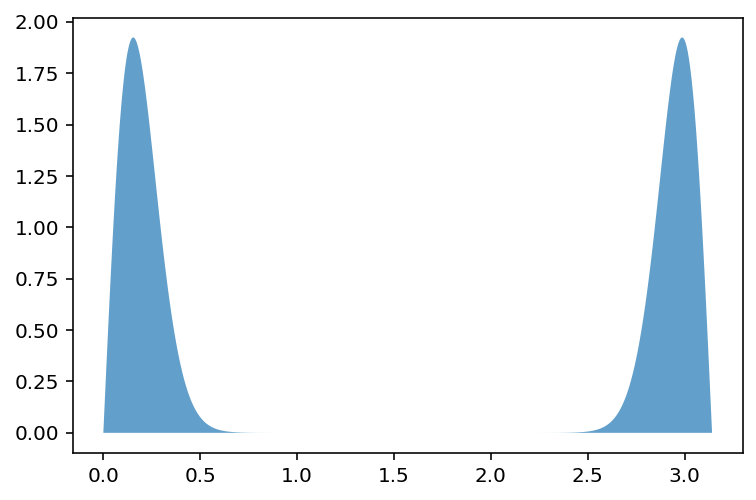

In [12]:
plt.fill_between(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)

In [13]:
theta_mean_y20 = integrate.simps(thetas * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [21]:
theta_mean_y20

1.5707963267948966

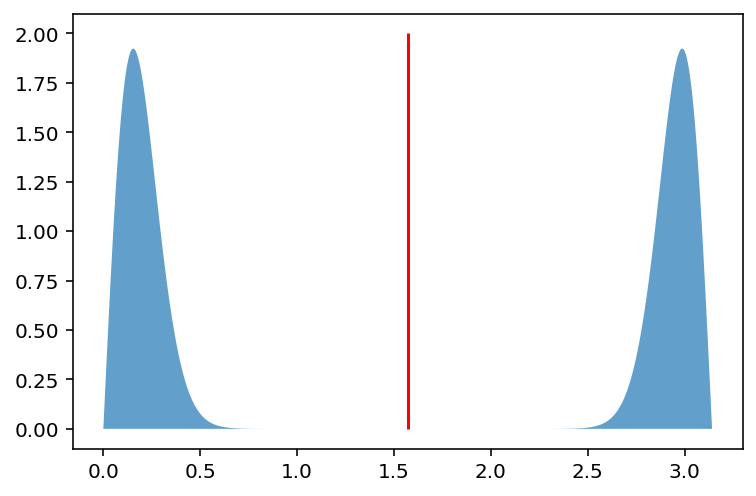

In [14]:
plt.fill_between(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)
plt.vlines(theta_mean_y20, 0,2, color='r')

### The second moment

In [15]:
theta_2nd_m_y20 = integrate.simps(thetas**2 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [19]:
theta_2nd_m_y20

4.363844635608555

### The variance

In [18]:
theta_var_y20 = integrate.simps((thetas - theta_mean_y20)**2 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [20]:
theta_var_y20

1.8964435353362155

In [22]:
theta_2nd_m_y20 - theta_mean_y20**2

1.896443535336216

### The third moment

In [16]:
theta_3nd_m_y20 = integrate.simps(thetas**3 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

### The forth moment

In [17]:
theta_4nd_m_y20 = integrate.simps(thetas**4 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

### Calculating mean absolute error for $\theta$

In [ ]:
theta_mean_t = t_ens_array.mean(axis=1)
theta_var_t = t_ens_array.var(axis=1)

Estimation
\begin{align}
\overline{f(t)} = \frac{1}{\tau} \int_{t_{min}}^{t_{min} + \tau} f (\xi)\, d \xi = \frac{1}{m} \sum_{k=1}^{m} f(t_{k})
\end{align}
Where
\begin{align}
t_{min} = \min{\left \{ t \in [0,T] | f(t) = \langle f \rangle \right \}}
\end{align}
and $\tau = [t_{min}, T]$, where $T = \mbox{MC_steps} \times dt$
​
Non-equilibrium time average with respect the equilibrium average
\begin{align}
\overline{\Delta f(t)} = f(t) - \langle f \rangle
\end{align}


### Index Function

In [ ]:
#def find_index_autocorr(auto_t):
#    for i in range(auto_t.shape[0]):
#        if auto_t[i] <= 0.:
#            return i

In [ ]:
#def mean_abs_errr_auto(auto_t):
#    idx = find_index_autocorr(auto_t)
#    abs_auto_t = abs(auto_t[idx:])
#    return abs_auto_t.mean()

This is crucial: As the mean value for the initial distribution (the uniform distribution on $\mathbb{S}^2$) is the same as the mean of the stationary distribution, we will use the index for which the variance reaches is stationary value for the first time

In [ ]:
#def find_index_mean(mean_t):
#    for i in range(mean_t.shape[0]):
#        if mean_t[i] >= np.pi/2:
#            return i

In [ ]:
def find_index_var(var_t):
    for i in range(var_t.shape[0]):
        if var_t[i] >= theta_var_y20:
            return i

### We have to calculate the mean value

In [ ]:
idx_var = find_index_var(var_t)

In [ ]:
def mean_abs_err_mean(mean_t):
    idx = idx_var
    abs_mean_e_t = abs(mean_t[idx:] - np.pi/2*np.ones(mean_t[idx:].shape[0]))
    return abs_mean_e_t.mean()

In [ ]:
def mean_abs_err_var(var_t):
    idx = find_index_var(var_t)
    abs_var_e_t = abs(var_t[idx:] - (np.pi**2/4 - 2) * np.ones(var_t[idx:].shape[0]))
    return abs_var_e_t.mean()